## Superposition of models with context vectors

This notebook implements the system of https://arxiv.org/pdf/1902.05522.pdf and trains it on the permuted MNIST dataset (which they discuss in their paper)

First we import tensorflow, numpy and matplotlib.

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"]=str("0")

The next cell defines a function to load in the MNIST csv files I downloaded and zipped (you gotta unzip them yourself), and then loads the data. This takes a minute because the method I am using to load data is slow.

In [15]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")


Visualize a digit, becasue it's always good to look at your data!

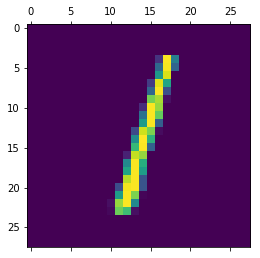

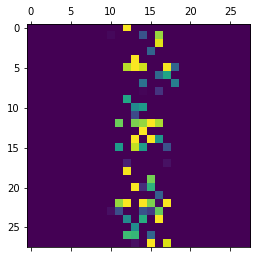

In [3]:
plt_data = np.reshape(test_data,[-1,28,28])

plt.matshow(np.reshape(test_data[2],[28,28]))
plt.show()

def get_batch_shuffle(x,p):
    y = np.reshape(x,[-1,28,28])
    z = np.array([y[:,p[i],i] for i in range(len(p))]).transpose([1,2,0])
    y = np.reshape(z,[-1,28*28])
    return y

shuff = np.array([np.random.choice(range(28),28,replace=False) for k in range(28)])

out_data = get_batch_shuffle(plt_data,shuff)
plt.matshow(np.reshape(out_data[2],[28,28]))
plt.show()

Set hyperparameters

In [4]:
batch_size = 16
data_size = len(test_data[0])
learning_rate = .001
n_epochs = 10000
n_labels = 10

Normalize the data. Note that we retain `m` and `s` so that we can normalize the test data in exactly the same way!

In [5]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

These placeholders represent the inputs and labels for the data, which we will fill in later.

I also get the shuffle indices for the different permutations of the MNIST dataset, and create contexts. 

Each layers weights get a context vector (thats why the `contexts` are a list). The context that the weights get multiplied by depends on `cindex` which specifies the context. 

In [16]:
tf.reset_default_graph()
ncontext = 10
layer_size = [256,256,256]
shuff = [np.array([np.random.choice(range(28),28,replace=False) for k in range(28)]) for j in range(ncontext)]
contexts = [tf.stop_gradient(tf.Variable(np.float32(np.random.randint(0,2,[ncontext,layer_size[k],layer_size[k-1] if k > 0 else 28*28])*2 - 1),trainable = False)) for k in range(len(layer_size))]
bias_contexts = [tf.stop_gradient(tf.Variable(np.float32(np.random.randint(0,2,[ncontext,layer_size[k]])*2 - 1),trainable = False)) for k in range(len(layer_size))]
cindex = tf.placeholder(tf.int32)

input_data = tf.placeholder(tf.float32,shape = (None,data_size))
labels = tf.placeholder(tf.float32,shape = (None,n_labels))

weights = [tf.Variable(np.float32(np.random.randn(layer_size[k],layer_size[k-1] if k > 0 else 28*28)/np.sqrt(layer_size[k-1] if k > 0 else 28*28)),trainable = True) for k in range(len(layer_size))]
bias = [tf.Variable(np.float32(np.zeros([layer_size[k]])),trainable = False) for k in range(len(layer_size))]


This defines the neural network layer by layer. Note that the last layer uses a linear activation function to generate *unnormalized log probabilities*. This is beause the loss function I used assumes the inputs are as such, and applies a softmax internally.

Note the multiplication of `weights[i]` by `contexts[i][cindex]` where `i` here is the layer index. This is the context vector, and `cindex` defines the context.

In [7]:
layer = []
layer.append(tf.nn.relu(tf.tensordot(input_data,weights[0]*contexts[0][cindex],axes = [[-1],[-1]]) + tf.expand_dims(bias[0]*bias_contexts[0][cindex],0)))

for k in range(1,len(layer_size)):
    layer.append(tf.nn.relu(tf.tensordot(layer[-1],weights[k]*contexts[k][cindex],axes = [[-1],[-1]]) + tf.expand_dims(bias[k]*bias_contexts[0][cindex],0)))

logits = tf.layers.dense(layer[-1],n_labels,activation = None)

Define the loss: average cross entropy loss between the NN output and the 1-hot encoded labels. Also create an ADAM optimizer and generate the training operation `train`.

The variable `scope` controls the parameters that are trained. If `scope = None` then all parameters are trained. by making the `scope` equal to a lyaer name (see above) you restrict training to only those variables. Play with this! In particular, the network learns much better if only `L1` weights are trained than if only `L3` weights are trained! Why?

In [8]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits))

scope = ""

regularize = .0001*tf.reduce_sum([tf.reduce_sum(t**2) for t in tf.trainable_variables(scope = scope)])

adam = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = adam.minimize(loss + regularize,var_list = tf.trainable_variables(scope = scope))

These helper functions take in a set of labels and generates a 1-hot encoding of them (`make_1hot`) and calculate the error based on the MAP estimate of the label (`MNIST_err`).

In [9]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

Define the training loop! 

At each step, pick a random batch of training data, run the training operation substituting in the batch of data for the placeholders above. 

Also periodically run the test data and record the train and test data.

In [10]:
def run_training_loop(use_context):
    
    init = tf.global_variables_initializer()
    #config = tf.ConfigProto(device_count = {'GPU': 0})
    sess = tf.Session()#config=config)
    sess.run(init)

    results = []
    print_freq = 500
    test_freq = 10
    normed_test = (test_data - m)/s
    normed_test = get_batch_shuffle(normed_test,shuff[0])
    test_label_1h = make_1hot(test_label)
    run_per_cont = 1000
    n_epochs = run_per_cont*ncontext

    for k in range(n_epochs):
        CIND = int(k/run_per_cont)
        
        if use_context:
            trind = CIND
        else:
            trind = 0
        
        b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
        batch_data = normed_data[b_index]
        batch_labels = make_1hot(train_label[b_index])

        batch_data = get_batch_shuffle(batch_data,shuff[CIND])

        _,train_loss,train_logits = sess.run([train,loss,logits],{input_data:batch_data,labels:batch_labels,cindex:trind})

        if k%test_freq == 0:
            test_loss,test_logits = sess.run([loss,logits],{input_data:normed_test,labels:test_label_1h,cindex:0})
            results.append([k,MNIST_err(test_label_1h,test_logits),MNIST_err(batch_labels,train_logits)])
        if k%print_freq == 0:
            print("{}\t{}\t{}".format(k,train_loss,test_loss))

    results = np.array(results)


    return results

In [11]:
context_run = [run_training_loop(True) for k in range(10)]
no_context_run = [run_training_loop(False) for k in range(10)]

0	2.404694080352783	2.2754387855529785
500	0.02380802109837532	0.28023865818977356
1000	2.3942434787750244	0.21361567080020905
1500	0.27972736954689026	0.30866336822509766
2000	2.484492301940918	0.30093926191329956
2500	0.11475536972284317	0.3313184976577759
3000	2.3690221309661865	0.3715708553791046
3500	0.24297326803207397	0.45334529876708984
4000	3.0371627807617188	0.49563515186309814
4500	0.039728906005620956	0.5873229503631592
5000	2.9336142539978027	0.5695240497589111
5500	0.18516436219215393	0.6950580477714539
6000	3.722909927368164	0.7765742540359497
6500	0.680729329586029	0.8388376235961914
7000	2.3422577381134033	0.85463947057724
7500	0.010359657928347588	1.0074132680892944
8000	3.2890453338623047	1.082963228225708
8500	0.19061750173568726	1.1987855434417725
9000	4.558748245239258	1.2850703001022339
9500	0.2109752595424652	1.3967275619506836
0	2.7043099403381348	2.2385873794555664
500	0.07089478522539139	0.2640332877635956
1000	2.638824462890625	0.24221020936965942
1500	0.106

Finally, visualize the results of training.

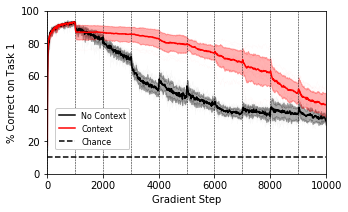

In [57]:
CON = np.mean(context_run,axis = 0)
CON_V = np.std(context_run,axis = 0)

NOCON = np.mean(no_context_run,axis = 0)
NOCON_V = np.std(no_context_run,axis = 0)

fig = plt.figure(figsize = (5,3))

#plt.plot(1+CON[:,0],1-CON[:,2],color = "r")
#plt.fill_between(1+CON[:,0],1-CON[:,2] - (CON_V[:,2]),1-CON[:,2] + (CON_V[:,2]),alpha = (.2),color = "r")

#plt.plot(1+NOCON[:,0],1-NOCON[:,2],color = "k")
#plt.fill_between(1+NOCON[:,0],1-NOCON[:,2]-(NOCON_V[:,2]),1-NOCON[:,2] + NOCON_V[:,2],color = "k",alpha = .2)

plt.plot(1+NOCON[:,0],NOCON[:,1],color = "k",label = "No Context")

for k in range(len(context_run)):
    plt.plot(1+no_context_run[k][:,0],no_context_run[k][:,1],color = "k",alpha = .1,linewidth = .1)
    plt.plot(1+context_run[k][:,0],context_run[k][:,1],color = "r",alpha = .1,linewidth = .1)
    
    plt.plot([k*1000,k*1000],[0,1],"k--",linewidth = .5)

plt.fill_between(1+NOCON[:,0],NOCON[:,1] - NOCON_V[:,1],NOCON[:,1] + NOCON_V[:,1],color = "k",alpha = .3)

plt.plot(1+CON[:,0],CON[:,1],"r",label = "Context")
plt.fill_between(1+CON[:,0],CON[:,1] - CON_V[:,1],CON[:,1] + CON_V[:,1],color = "r",alpha = .3)

plt.plot(1+NOCON[:,0],1-np.ones_like(NOCON[:,1])*.9,"k--",label = "Chance")

LLOC = .15
plt.legend(loc = ((LLOC - .1)*3/5,LLOC),fontsize = 8,framealpha = 1)
plt.yticks([0,.2,.4,.6,.8,1],[0,20,40,60,80,100])
plt.ylim([0,1])
plt.xlim([0,10000])
plt.xlabel("Gradient Step")
plt.ylabel("% Correct on Task 1")
plt.savefig("./Simple_permuting_MNIST.pdf",bbox_inches = "tight")
#plt.xscale("log")
plt.show()